In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import threading
from IPython.display import clear_output

In [2]:
# exquisite acronym explanation (also sounds like lean):
# R - recurrent
# E - embedding
# A - approximation
# N - network

In [3]:
# embeddings mode
model_file = fr"./embedding_models/wiki_model3.model"
embeddings_model = Word2Vec.load(model_file)

vector_size = embeddings_model.vector_size
window = embeddings_model.window

# neural net settings
context_length = 8
input_size = context_length * vector_size + vector_size # account for previous block and current fresh inputs

# dataset
train_dataset_path = fr"./datasets/wiki_dump_train.txt"
test_dataset_path = fr"./datasets/wiki_dump_test.txt"

unique_examples_train = 1024 * 8 * 6 * 2
unique_examples_test = 4096

# training
train_epochs = 32
warmup_epochs = 4

initial_warmup_lr = 0.0000001
final_warmup_lr = 0.00001
initial_train_lr = 0.00001
final_train_lr = 0.0000003
beta1 = 0.9
beta2 = 0.95
epsilon = 0.00000001

loss = nn.MSELoss()

train_optimizer = torch.optim.Adam
warmup_optimizer = torch.optim.Adam

train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
warmup_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

train_batch_size = 256 * 3
test_batch_size = 256 * 3 # smaller specifically to get more datapoints per test run
test_loop_epoch = 4

plot_graphs = True

# pytorch
run_device = torch.device("cuda")
storage_device = torch.device("cpu")

In [4]:
class REAN_block(nn.Module):
    def __init__(self, input_size):
        super(REAN_block, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, vector_size)

    def forward(self, prev_block: torch.Tensor, fresh_input: torch.Tensor) -> torch.Tensor:
        x = torch.cat((prev_block, fresh_input), dim=1)
        
        x = x / 5
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        
        x = x * 5
        
        return x

In [5]:
class REAN(nn.Module):
    def __init__(self, input_size):
        super(REAN, self).__init__()
        
        self.block1 = REAN_block(input_size)
        self.block2 = REAN_block(input_size)
        self.block3 = REAN_block(input_size)
        self.block4 = REAN_block(input_size)
        self.block5 = REAN_block(input_size)
        self.block6 = REAN_block(input_size)
        self.block7 = REAN_block(input_size)
        self.block8 = REAN_block(input_size)
        self.block9 = REAN_block(input_size)
        self.block10 = REAN_block(input_size)
        self.block11 = REAN_block(input_size)
        self.block12 = REAN_block(input_size)

    def forward(self, current_segment: torch.Tensor) -> torch.Tensor:
        # keep an x's clone from the start so the blocks get fresh input
        self.fresh_input = current_segment.clone()
        
        self.fresh_input = self.fresh_input.reshape(current_segment.shape[0], vector_size * context_length)
        
        # supplement the (currently non existant) previous block's output with the latest word
        current_segment = self.block1(current_segment[:, -1], self.fresh_input)
        current_segment = self.block2(current_segment, self.fresh_input)
        current_segment = self.block3(current_segment, self.fresh_input)
        current_segment = self.block4(current_segment, self.fresh_input)
        current_segment = self.block5(current_segment, self.fresh_input)
        current_segment = self.block6(current_segment, self.fresh_input)
        current_segment = self.block7(current_segment, self.fresh_input)
        current_segment = self.block8(current_segment, self.fresh_input)
        current_segment = self.block9(current_segment, self.fresh_input)
        current_segment = self.block10(current_segment, self.fresh_input)
        current_segment = self.block11(current_segment, self.fresh_input)
        current_segment = self.block12(current_segment, self.fresh_input)
        
        return current_segment

net = REAN(input_size)
net.to(run_device)

train_optimizer = train_optimizer(net.parameters(), lr=initial_train_lr, betas=(beta1, beta2), eps=epsilon)
warmup_optimizer = warmup_optimizer(net.parameters(), lr=initial_warmup_lr, betas=(beta1, beta2), eps=epsilon)

train_scheduler = train_scheduler(train_optimizer, T_max=train_epochs, eta_min=final_train_lr)
warmup_scheduler = warmup_scheduler(warmup_optimizer, T_max=warmup_epochs, eta_min=final_warmup_lr)

c:\Users\user\anaconda3\envs\CONDA_VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def vectorize_sentence(sentence: list[str], model: Word2Vec, default: int = 0) -> np.ndarray:
    """
    encodes all words in a given list to corresponding vectors in given model.
    words not found in the model will be given a vector with "default" value
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding
        default (int): fill vector with this value if word is not found in model
    
    returns:
        np.array: 2d array with dim1 = len(sentence) and dim2 = model.vector_size
    """
    
    # generate inital array with default values
    vectorized = np.ones((len(sentence), model.vector_size)) * default
    
    # loop over every word in list
    for current_word, current_word_idx in zip(sentence, range(len(sentence))):
        # only add correct values if word is in model, otherwise leave as default
        if current_word in model.wv:
            vectorized[current_word_idx] *= 0
            vectorized[current_word_idx] += model.wv[current_word]
    
    return vectorized

In [7]:
def devectorize_sentence(vectorized_sentence: np.array, model: Word2Vec) -> list:
    """
    decodes vectors into nearest word found in model
    
    parameters:
        vectorized_sentence (np.array): 2d arrat with vectors of words to be decoded
        model (Word2Vec): model to use when decoding
    
    returns:
        list: list of strings (words) whos vectors most closely match those provided
    """
    
    result = []
    
    # go over all words and find closest match in model
    for current_word in vectorized_sentence:
        result.append(model.wv.similar_by_vector(current_word)[0][0])
    
    return result

In [8]:
def pad_or_truncate(suspected_tensor: torch.tensor, target_length: int, default: int=0) -> torch.Tensor:
    """
    pads or truncates a given tensor along dim 0 to target_length with "default" as padding
    
    parameters:
        suspected_tensor (torch.tensor): tensor to pad or truncate
        target_length (int): target length of tensor
        default (int): value to use for padding
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    if len(suspected_tensor) < target_length:
        # pad
        suspected_tensor = torch.cat((torch.ones(target_length - len(suspected_tensor), suspected_tensor.shape[1], dtype=torch.float32, device=suspected_tensor.device) * default, suspected_tensor))
    else:
        # truncate
        suspected_tensor = suspected_tensor[-target_length:]
    
    return suspected_tensor

In [9]:
def prepare_sentence_for_net(sentence: list, model: Word2Vec, context_length: int, flatten: bool=True, used_device: torch.device=run_device) -> torch.Tensor:
    """
    turns a sentence (list of strings) into a tensor that can be fed directly into the network
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding sentence
        context_length (int): length of context to consider when encoding, should be same as network's
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    # encode sentence to np.array
    vectorized = vectorize_sentence(sentence, model)
    vectorized_tensor = torch.from_numpy(vectorized).to(used_device).to(torch.float32)
    
    # pad or truncate
    vectorized_tensor = pad_or_truncate(vectorized_tensor, context_length)
    
    if flatten:
        # flatten to fit into first fc layer of the net
        vectorized_tensor = vectorized_tensor.flatten()
    
    return vectorized_tensor

In [10]:
def predict_word(current_segment: list, net: REAN, embeddings_model: Word2Vec) -> str:
    """
    uses the net and the model to predict the next word to fit the given sentence
    
    parameters:
        sentence (list): list of strings (words)
        net (GPT_like): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
    
    returns:
        str: predicted word
    """
    encoded_segment = prepare_sentence_for_net(current_segment, embeddings_model, context_length, flatten=False)
    
    # run sentence
    output = net(encoded_segment.unsqueeze(0))
    
    # add the net's vector to the end of the current segment
    target = output + encoded_segment[-1]
    
    # decode most similar word to whatever net predicted
    predicted_word = embeddings_model.wv.similar_by_vector(target.detach().squeeze(0).cpu().numpy())[0][0]
    
    return predicted_word

In [11]:
def predict_sequence(sentence: list, net: REAN, embeddings_model: Word2Vec, num_completions: int) -> list:
    """
    predicts multiple words at the end of the given sentence
    
    parameters:
        sentence (list): list of strings (words)
        net (GPT_like): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
        num_completions (int): number of words to predict
    
    returns:
        list: list of words to be appended to given sentence
    """
    
    predicted_result = sentence
    
    for _ in tqdm(range(num_completions)):
        # give the network the full context to work with, while only collecting the predicted part into the result
        predicted_result.append(predict_word(predicted_result, net, embeddings_model))
    
    return predicted_result

In [12]:
class REAN_dataset(Dataset):
    def load_dataset_chunk(self, path: str, num_words: int, seek_start: int, sep: str = " ") -> tuple[list, bool, int]:
        """
        function to load a chunk of the dataset where the words are separated by "sep" into a list
        
        parameters:
            path (str): path to the dataset txt file
            num_words (int): number of words to load
            seek_start (int): start char to pull words from
            sep (str, optional): separator in the dataset, defaults to space " "
        
        returns:
            list: list of strings (loaded words), is EOF hit, seek position to move 1 word forward
        """
        
        # some safety checks so later code looks cleaner
        self.num_words = max(0, num_words)
        self.seek_start = max(0, seek_start)
        
        self.words = []
        self.current_word_idx = 0
        self.word_buffer = ""
        self.current_seek = seek_start
        self.next_seek = 0
        self.first_word_flag = True

        with open(path, 'r', encoding='utf-8', errors='ignore') as self.file:
            self.file.seek(seek_start)
            
            # loop over all chars after seek_start
            while True:
                self.char = self.file.read(1)
                self.current_seek += 1
                
                # end of file, return whatever has been collected immediately
                if not self.char:
                    return self.words, True, self.next_seek
                
                # is a separator between words hit
                if self.char == sep or self.char.isspace():
                    if self.word_buffer:
                        if self.current_word_idx < self.num_words:
                            self.words.append(self.word_buffer)
                        
                        self.current_word_idx += 1
                        self.word_buffer = ""
                    
                    if self.current_word_idx >= self.num_words:
                        break
                    
                    # the first word is covered, this is where the next chunk is going to be loaded from
                    if self.first_word_flag:
                        self.first_word_flag = False
                        self.next_seek = self.current_seek
                else:
                    self.word_buffer += self.char

        return self.words, False, self.next_seek
    
    def __init__(self, path, num_unique_examples, context_length, embeddings_model):
        self.prompts = []
        self.target_diffs = []
        
        self.next_seek = 0
        
        for _ in tqdm(range(num_unique_examples)):
            # load current example
            self.current_chunk, self.eof, self.next_seek = self.load_dataset_chunk(path, context_length + 1, self.next_seek)
            
            # in case file is too small for requested size
            if self.eof:
                print("eof hit, early stop")
                print("dataset has been generated succesfully, even though it might be smaller than you expect, size: ", len(self.prompts))
                return
            
            self.encoded_chunk = prepare_sentence_for_net(self.current_chunk, embeddings_model, len(self.current_chunk), flatten=False, used_device=storage_device)
            
            # everything before the word were supposted to predict + the word to be predicted
            self.context = self.encoded_chunk[:-1]
            self.target = self.encoded_chunk[-1]
            
            # diff is the vector required to jump from the last word of the senttence, to the next word to be predicted
            self.target_diff = self.target - self.context[-1]
            
            # add newly generated data
            self.prompts.append(self.context)
            self.target_diffs.append(self.target_diff)
        
        print("dataset has been generated succesfully, size: ", len(self.prompts))
        
    def __len__(self):
        return len(self.prompts)
    
    def __getitem__(self, index):
        return self.prompts[index], self.target_diffs[index]

In [13]:
train_dataset = REAN_dataset(train_dataset_path, unique_examples_train, context_length, embeddings_model)
test_dataset = REAN_dataset(test_dataset_path, unique_examples_test, context_length, embeddings_model)

100%|██████████| 98304/98304 [00:26<00:00, 3708.79it/s]


dataset has been generated succesfully, size:  98304


100%|██████████| 4096/4096 [00:01<00:00, 3741.69it/s]

dataset has been generated succesfully, size:  4096


In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

In [15]:
train_loss_graph = []
test_loss_graph = []
learning_rate_graph = []

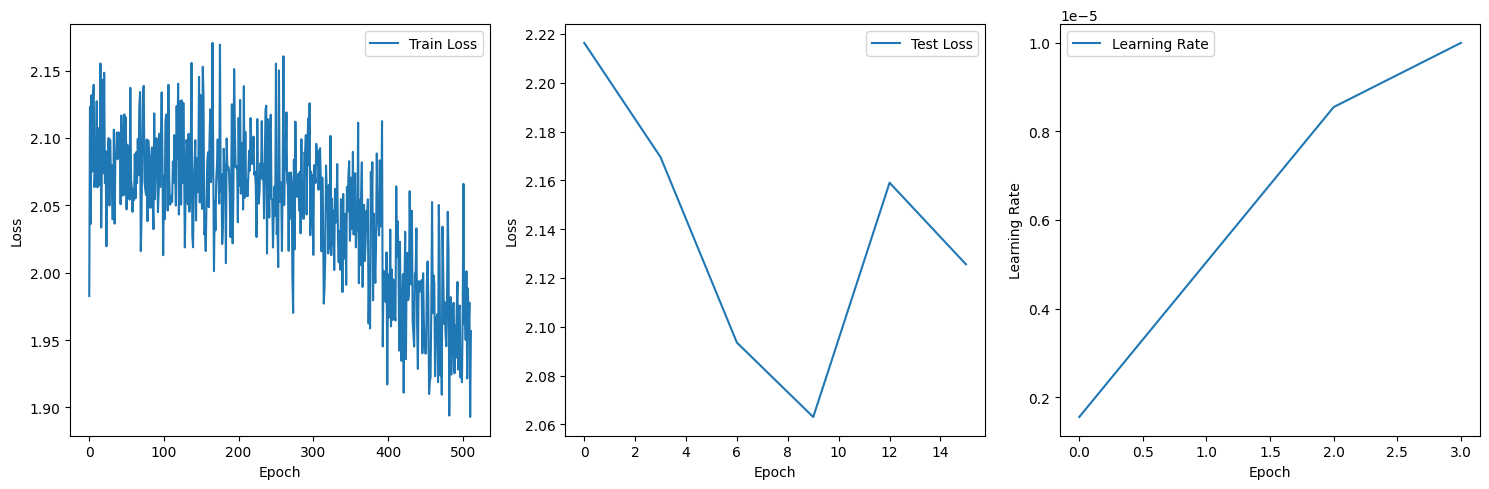

100%|██████████| 4/4 [01:44<00:00, 26.24s/it]


In [16]:
for epoch in tqdm(range(warmup_epochs)):
    # training loop
    for current_segment, target in train_loader:
        # move batch to gpu
        current_segment = current_segment.to(run_device)
        target = target.to(run_device)
        
        # train batch
        warmup_optimizer.zero_grad()
        train_outputs = net(current_segment)
        train_loss_value = loss(train_outputs, target)
        train_loss_value.backward()
        warmup_optimizer.step()
        
        # collect performance metrics
        train_loss_graph.append(train_loss_value.item())
    
    # eval loop
    if epoch % test_loop_epoch == 0:
        with torch.no_grad():
            for test_current_segment, test_target in test_loader:
                # move batch to gpu
                test_current_segment = test_current_segment.to(run_device)
                test_target = test_target.to(run_device)
                
                # run test
                test_outputs = net(test_current_segment)
                test_loss_value = loss(test_outputs, test_target)
                
                # collect performance metrics
                test_loss_graph.append(test_loss_value.item())
    
    warmup_scheduler.step()
    
    # collect perforamce metrics
    learning_rate_graph.append(warmup_optimizer.param_groups[0]['lr'])

    # plot everything
    if plot_graphs:
        clear_output(wait=True)
        
        plt.figure(figsize=(15, 5))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(train_loss_graph, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot testing loss
        plt.subplot(1, 3, 2)
        plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot learning rate
        plt.subplot(1, 3, 3)
        plt.plot(learning_rate_graph, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()

        plt.tight_layout()
        plt.show()

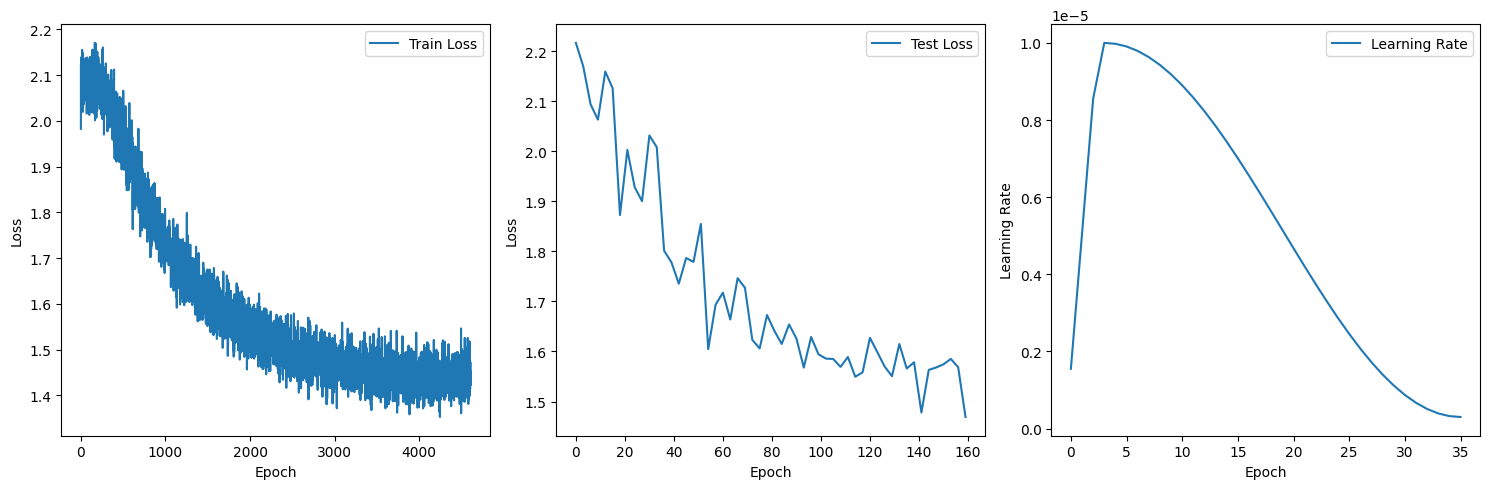

100%|██████████| 32/32 [15:25<00:00, 28.94s/it]


In [17]:
for epoch in tqdm(range(train_epochs)):
    # training loop
    for current_segment, target in train_loader:
        # move batch to gpu
        current_segment = current_segment.to(run_device)
        target = target.to(run_device)
        
        # train batch
        train_optimizer.zero_grad()
        train_outputs = net(current_segment)
        train_loss_value = loss(train_outputs, target)
        train_loss_value.backward()
        train_optimizer.step()
        
        # collect performance metrics
        train_loss_graph.append(train_loss_value.item())
    
    # eval loop
    if epoch % test_loop_epoch == 0:
        with torch.no_grad():
            for test_current_segment, test_target in test_loader:
                # move batch to gpu
                test_current_segment = test_current_segment.to(run_device)
                test_target = test_target.to(run_device)
                
                # run test
                test_outputs = net(test_current_segment)
                test_loss_value = loss(test_outputs, test_target)
                
                # collect performance metrics
                test_loss_graph.append(test_loss_value.item())
    
    train_scheduler.step()
    
    # collect perforamce metrics
    learning_rate_graph.append(train_optimizer.param_groups[0]['lr'])

    # plot everything
    if plot_graphs:
        clear_output(wait=True)
        
        plt.figure(figsize=(15, 5))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(train_loss_graph, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot testing loss
        plt.subplot(1, 3, 2)
        plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot learning rate
        plt.subplot(1, 3, 3)
        plt.plot(learning_rate_graph, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [18]:
#torch.save(net.state_dict(), 'no_attention_mech.pth')

In [22]:
sentence = "there were no available".split(" ")

In [23]:
" ".join(predict_sequence(sentence, net, embeddings_model, 32))

100%|██████████| 32/32 [00:02<00:00, 13.63it/s]


'there were no available available available available available available available available available available available available available available available available available available available available available available available available available available available available available available available available available'